# Import data and modules

In [1]:
# import libraries
from math import * 
import math
import sympy as sy
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib widget
import trackpy as tp
import os
import pickle
import re

from scipy import integrate
from scipy import signal
from scipy.signal import find_peaks
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import fft, fftfreq
from scipy import optimize
from sklearn.cluster import DBSCAN
from matplotlib.widgets import SpanSelector
from scipy.integrate import simpson
from numpy import trapz

# odr function from scipy package
# is used to perform ODR regression
from scipy import odr  
from scipy.optimize import leastsq

# Load all the functions used in this program
%run functions.ipynb

# --> Change globally the fonts of the plots:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({ 'font.sans-serif':'Arial'})
# to restore defaults use:    mpl.rc_file_defaults()


In [2]:
# Define which fibril you would like to analyze:
ROI = '2_1_2'
fibril_nr = '4_2'


folder = f'loc_filt_GPU_results_{ROI}/'
fibrils = [f for f in os.listdir(folder) 
           if os.path.isdir(os.path.join(folder, f))]

# Specify which fibril should be analysed
fibril = f'fibril_{fibril_nr}'

# Create results folder:
path_to_folder = folder+f'{fibril}/'
path_to_spline_results = path_to_folder+f'/analysis_ROI_{ROI}_{fibril}/'
results_folder = path_to_folder+f'results_ROI_{ROI}_{fibril}/'

# Check if the folder already exists
if not os.path.exists(results_folder):
    os.mkdir(results_folder)
    print(f"Folder '{results_folder}' created.")
else:
    print(f"Folder '{results_folder}' already exists.")
    

# import AFM file
locW = pd.read_csv(path_to_spline_results+f'AFM_wet_data_continue.csv')

# import the STORM files
# Define the regex pattern
pattern_locs = re.compile(r'storm_data_continue_def')

# Filter files that match the pattern
matching_STORM_loc_files = [f for f in os.listdir(path_to_spline_results) if pattern_locs.match(f)]
matching_STORM_loc_files.sort()

# Construct full paths for the matched STORM files
matching_STORM_paths = [os.path.join(path_to_spline_results,
                                     f) for f in matching_STORM_loc_files]

STORM_locs_list = []
STORM_defocus_list = []
for j in matching_STORM_paths:
    STORM_locs_list += [pd.read_csv(j)]
    STORM_defocus_list += [j.split('continue_',1)[1][:-4]]
# This list contains all the different defocus values


Folder 'loc_filt_GPU_results_2_1_2/fibril_4_2/results_ROI_2_1_2_fibril_4_2/' already exists.


In [3]:
matching_STORM_loc_files

['storm_data_continue_def_579_mid_138_n133_n1.33_n1518.csv',
 'storm_data_continue_def_579_mid_138_n133_n1.38_n1518.csv',
 'storm_data_continue_def_579_mid_138_n133_n1.42_n1518.csv',
 'storm_data_continue_def_579_mid_138_n133_n1.44_n1518.csv',
 'storm_data_continue_def_579_mid_138_n133_n1.46_n1518.csv',
 'storm_data_continue_def_579_mid_138_n133_n1.48_n1518.csv',
 'storm_data_continue_def_579_mid_138_n133_n1.4_n1518.csv',
 'storm_data_continue_def_579_mid_138_n133_n1.518_n1518.csv']

In [4]:
# check if you already have a result dict:
if os.path.exists(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_result_list.pkl'):
    with open(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_result_list.pkl',
              'rb') as file:
        result_list = pickle.load(file)

else: # Otherwise make a new result dict
    result_list = pd.DataFrame(columns=['ROI','fibril','refractive_index','defocus',
                                        'eps_AFM', 'min_AFM','N_filt', 'LLR_filt', 'eps_filt', 'min_sample_filt', 
                                        'ws', 'overlap', 'n_ws', 'overlap_n', 'def_filter',  
                                        
                                        'H_AFM_W','H_polyfit','H_bin',
                                        'sliding_window_height','LLR'])
    with open(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_result_list.pkl',
              'wb') as file:
        pickle.dump(result_list, file)

In [5]:
Q = str(input('Do you want to specify new values for eps_AFM and min_AFM ?'))
if Q == 'y':
    eps_AFM = int(input('please define a new value for eps_AFM (default = 5:)'))
    min_AFM = int(input('please define a new value for min_AFM (default = 7:)'))
else:
    eps_AFM, min_AFM = result_list.iloc[1]['eps_AFM'], result_list.iloc[1]['min_AFM']

Do you want to specify new values for eps_AFM and min_AFM ?


# Analysing the AFM-data

A·exp[-0.5·((x-μ)/σ)^2]

Fit Values (in nm):
µ = 0.07, σ = 172.78


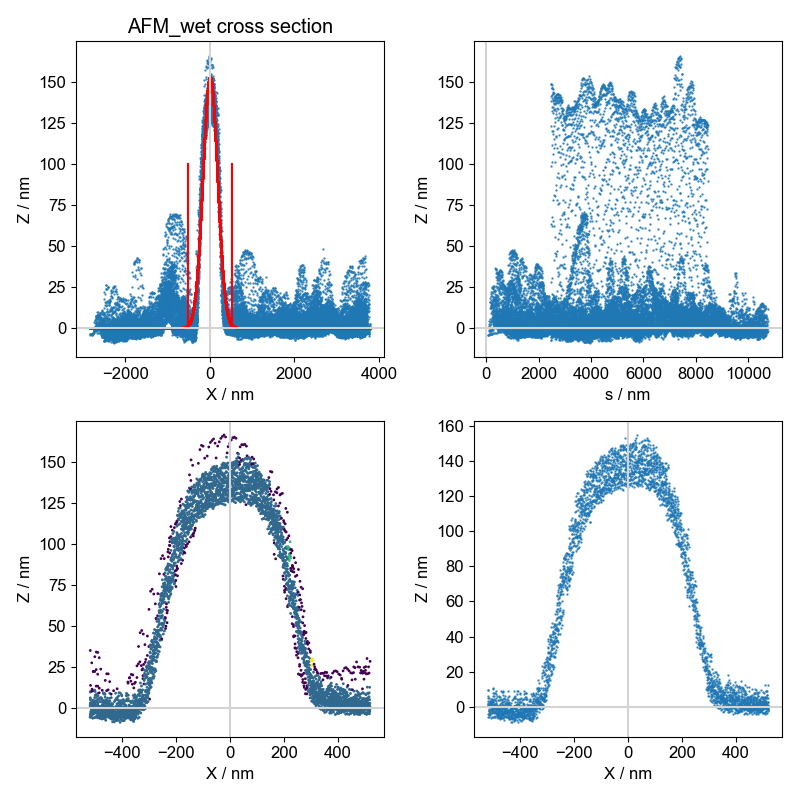

In [6]:
# eps_AFM = 5
# min_AFM = 5

### Start of the program
locW_c = locW.copy()

# Automatic filtering 
x_values = locW['X']
# Gaussian fit
fitfunc = lambda p, x: p[0] * np.exp(-0.5 * ((x - p[1]) / p[2])**2)
errfunc = lambda p, x, y: y - fitfunc(p, x)
params, _ = leastsq(errfunc, [1.0, 0.5, 0.5], args=(locW['X'],locW['Y']))
c = [round(p, 2) for p in params]

# Fit description
textbox = f"A·exp[-0.5·((x-μ)/σ)^2]\n\nFit Values (in nm):\nµ = {c[1]}, σ = {c[2]}"
print(textbox)
locW_c = filt(locW_c,'X',c[1]-3*c[2],c[1]+3*c[2])
# filtering left and right of the fibril using 3 σ

# AFM Wet data clustering
locW_c = locW_c.sort_values('X')
## Cleaning up the AFM fibril by using the DBSCAN clustering algorithmus
x_locw = locW_c.loc[:, ['X','Y']].values
dbscanw = DBSCAN(eps = eps_AFM, min_samples = min_AFM).fit(x_locw) # fitting the model
labelsw = dbscanw.labels_# getting the labels
locW_c['cluster2']=labelsw
locW_c = locW_c[locW_c['cluster2']>=0]

fib_filtered, ax =plt.subplots(2,2,figsize=(8,8))
ax[0][0].scatter(locW['X'],locW['Y'], s=0.5, alpha=0.8)

# Plot histogram and fit
ax[0][0].scatter(x_values, fitfunc(c, x_values), c='red', label='Gauss fit',s=1)
ax[0][0].plot([c[1]-3*c[2],c[1]-3*c[2]],[0,100],c='r')
ax[0][0].plot([c[1]+3*c[2],c[1]+3*c[2]],[0,100],c='r')
ax[0][1].scatter(locW['s'],locW['Y'], s=0.5, alpha=0.8)
ax[1][0].scatter(x_locw[:, 0], x_locw[:,1], c = labelsw, s=1) # plotting the clusters
ax[1][1].scatter(locW_c['X'],locW_c['Y'], s=0.5, alpha=0.8)
cross(ax[0][0]), cross(ax[0][1]), cross(ax[1][0]), cross(ax[1][1])
ax[0][0].set_xlabel("X / nm"),ax[0][0].set_ylabel("Z / nm")
ax[0][0].set_title("AFM_wet cross section")
ax[0][1].set_xlabel("s / nm"), ax[0][1].set_ylabel("Z / nm")
ax[1][0].set_xlabel("X / nm"),ax[1][0].set_ylabel("Z / nm")
ax[1][1].set_xlabel("X / nm"),ax[1][1].set_ylabel("Z / nm")
# ax[2][2].axis('equal'), ax[2][2].set_xlabel("X / nm"), ax[2][2].set_ylabel("Z / nm")

fib_filtered.tight_layout()
fib_filtered.savefig(results_folder+'AFM_fib_filtered.png',dpi=600)   
# save the figure to file
plt.show()

In [7]:
Data_n_AFM = locW_c.copy()
Data_n_AFM = Data_n_AFM.sort_values('X')

# bin the data along the X-axis
X_range = max(Data_n_AFM['X']) + abs(min(Data_n_AFM['X']))
bin_width = 20

num_of_bins = int(X_range/bin_width)
c_data = pd.cut(Data_n_AFM['X'],bins=num_of_bins) # bins with equal width
Data_n_AFM['bin'] = c_data
Data_n_AFM_mean = Data_n_AFM.groupby(['bin']).median()
Data_n_AFM_mean = Data_n_AFM_mean.sort_values('X')
AFM_mean_height = list(Data_n_AFM_mean['Y'])

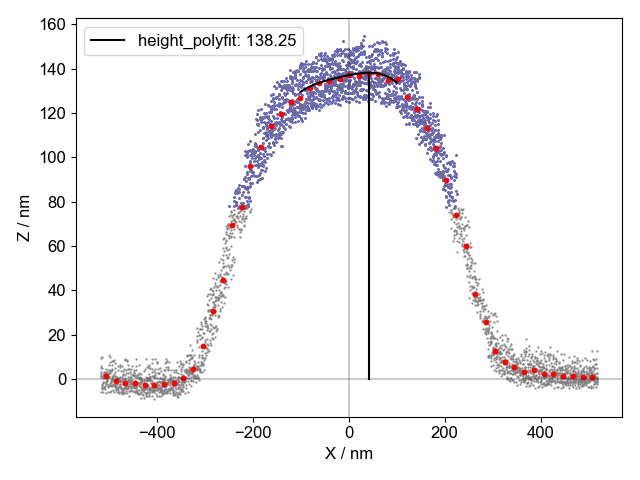

In [8]:
Data_n_AFM = locW_c.copy()
upper_cutoff1 = np.mean(Data_n_AFM['Y'])
upper_cutoff2 = max(Data_n_AFM['Y'])*0.5

if upper_cutoff1 < upper_cutoff2:
    upper_cutoff = upper_cutoff2
else:
    upper_cutoff = upper_cutoff1

AFM_Data_upper_half = Data_n_AFM[Data_n_AFM['Y']>upper_cutoff]

# make the fit for the upper data points
upper_fit = np.polyfit(AFM_Data_upper_half['X'],AFM_Data_upper_half['Y'],6)
x_upper_fit = np.linspace(-100,100,1000)
y_upper_fit = np.polyval(upper_fit,x_upper_fit)

# save the upper point:
height_polyfit_AFM = max(y_upper_fit)
x_AFM_fit_max = x_upper_fit[list(y_upper_fit).index(max(y_upper_fit))]


# Simple Height approach:
fig_AFM_cross_section_height, ax1=plt.subplots()
ax1.scatter(AFM_Data_upper_half['X'],AFM_Data_upper_half['Y'],s=0.8,alpha=0.9,c='b') 
ax1.scatter(Data_n_AFM['X'],Data_n_AFM['Y'], s=0.5, alpha=0.8,c='grey')
ax1.plot(x_upper_fit,y_upper_fit,color='k')
ax1.plot([x_AFM_fit_max,x_AFM_fit_max],[0,height_polyfit_AFM],color='k',
            label = f'height_polyfit: {round(height_polyfit_AFM,2)}')
ax1.set_xlabel("X / nm") # X-axis label
ax1.set_ylabel("Z / nm") # Y-axis label
# ax1.axis('equal')

ax1.scatter(Data_n_AFM_mean['X'], AFM_mean_height,color='r',s=10) 
# ax1.plot([x_AFM_fib_height,x_AFM_fib_height],[0,height_bin],
#          color='r',label=f'binned height: {height_bin} nm')

ax1.axhline(color='k',alpha=0.2)
ax1.axvline(color='k',alpha=0.2)
ax1.legend()
# ax1.set_title(f'{def_para}')
plt.tight_layout()

In [9]:
Q = str(input('Do you want to specify new values for the binning ?'))
if Q == 'y':
    ws = int(input('please define a new value for ws (default = 20:)'))
    overlap = float(input('please define a new value for overlap (default = 0.5:)'))
    n_ws = int(input('please define a new value for n_ws (default = 40:)'))
    overlap_n = float(input('please define a new value for overlap_n (default = 0.5:)'))
else:
    ws, overlap = result_list.iloc[1]['ws'], result_list.iloc[1]['overlap']
    n_ws, overlap_n = result_list.iloc[1]['n_ws'], result_list.iloc[1]['overlap_n'] 
    

Do you want to specify new values for the binning ?


-517.39 517.87


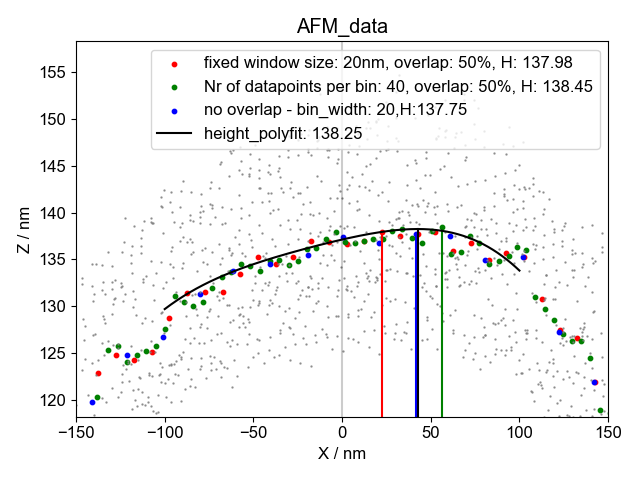

In [10]:

AFM_sw_H,x_max_sw,y_max_sw = sliding_win(Data_n_AFM,ws,overlap)
# sliding window fixed binning

AFM_sw_H_n,x_max_sw_n,y_max_sw_n = sliding_win_n(Data_n_AFM,n_ws,overlap_n)
# sliding window binning datapoints

df_H,x_H_height,H_height = bin_data_by_x(Data_n_AFM,ws)
# binning with fixed binsize


# -> For the AFM height we select the binning Nr of locs method:
W_AFM_fib_height = np.array([y_max_sw,y_max_sw_n,H_height,height_polyfit_AFM])
W_AFM_fib_height = [round(j,2) for j in W_AFM_fib_height]


# Plot the results:
fig,ax1 = plt.subplots()
# sliding window fixed binning
ax1.scatter(AFM_sw_H[0],AFM_sw_H[1],c='r',
            label = f'fixed window size: {ws}nm, '+
            f'overlap: {int(overlap*100)}%, H: {round(y_max_sw,2)}',s=10)
ax1.plot([x_max_sw,x_max_sw],[0,y_max_sw],c='r')

# sliding window binning datapoints
ax1.scatter(AFM_sw_H_n[0],AFM_sw_H_n[1],c='g',
            label = f'Nr of datapoints per bin: {n_ws},'+
            f' overlap: {int(overlap_n*100)}%, H: {round(y_max_sw_n,2)}',s=10)
ax1.plot([x_max_sw_n,x_max_sw_n],[0,y_max_sw_n],c='g')

# binning with fixed binsize
ax1.scatter(df_H['X'], df_H['Y'],
            color='b',label = f'no overlap - bin_width: {ws},'+
            f'H:{round(H_height,2)}',s=10) 
ax1.plot([x_H_height,x_H_height],[0,H_height],c='b')

# Plotting the polynome results
ax1.plot([x_AFM_fit_max,x_AFM_fit_max],[0,height_polyfit_AFM],color='k',
            label = f'height_polyfit: {round(height_polyfit_AFM,2)}')

# plotting the rest of the data
ax1.scatter(Data_n_AFM['X'],Data_n_AFM['Y'], s=0.5, alpha=0.8,c='grey')
ax1.plot(x_upper_fit,y_upper_fit,color='k')
ax1.set_xlabel("X / nm"), ax1.set_ylabel("Z / nm") 
ax1.axhline(color='k',alpha=0.2), ax1.axvline(color='k',alpha=0.2)
ax1.legend(), ax1.set_title('AFM_data')
ax1.set_ylim(height_polyfit_AFM-20,height_polyfit_AFM+20)
ax1.set_xlim(-150,150)
plt.tight_layout()
fig.savefig(results_folder+'fig_AFM_cross_section_height.png',dpi=600) 

140.74749100000002 1.3146081583190483 139.07594500000002 0.8513219907737618


(array([ 18.,  70., 211., 297., 205., 133.,  52.,   8.,   4.,   2.]),
 array([136.825, 137.42 , 138.015, 138.61 , 139.205, 139.8  , 140.395,
        140.99 , 141.585, 142.18 , 142.775]),
 <BarContainer object of 10 artists>)

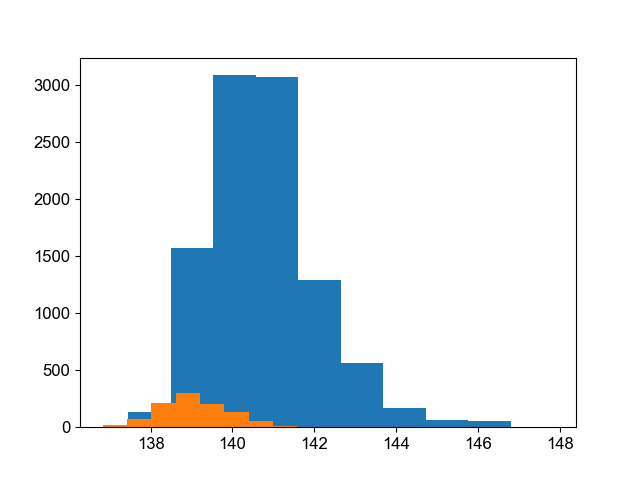

In [11]:

# b bootstrap, r resampling
er_h_b,m_b,sdt_b,er_h_r,m_r,sdt_r = calc_error(Data_n_AFM,n_ws,overlap_n)

print(m_b,sdt_b,m_r,sdt_r)
fig,ax = plt.subplots()
ax.hist(er_h_b)
ax.hist(er_h_r)

In [12]:

AFM_error = {'er_h_b':er_h_b,'m_b':m_b,'sdt_b':sdt_b,
             'er_h_r':er_h_r,'m_r':m_r,'sdt_r':sdt_r}
# Save the AFM_data_profile:
Data_n_AFM.to_csv(results_folder+f'Data_n_AFM_ROI_{ROI}_fib_{fibril_nr}.csv')

with open(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_AFM_error.pkl','wb') as file:
    pickle.dump(AFM_error, file)
    


## Calculate the difference in the bg heights:

In [1]:
# This difference is added to the SMLM heights later on, 
# to account for error by collagen debris on the coverslip surface.

In [13]:
# Define the border region left and right of the AFM image:
left_border, right_border = min(locW_c['X']), max(locW_c['X'])
Data_AFM_bg_side = locW.copy()
Data_AFM_bg_side = Data_AFM_bg_side[(Data_AFM_bg_side['X'] < left_border) | 
                                    (Data_AFM_bg_side['X'] > right_border)]

# Calculate the mean position of the bg "locs":
bg_side_mean = np.mean(Data_AFM_bg_side['Y'])
bg_side_median = np.median(Data_AFM_bg_side['Y'])
bg_side_std = np.std(Data_AFM_bg_side['Y'])




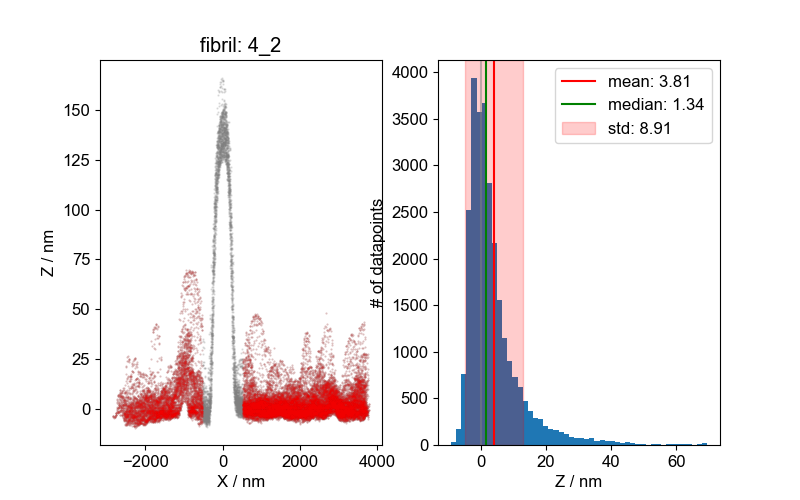

In [14]:
fig, ax=plt.subplots(1,2,figsize=(8,5))
ax[0].scatter(locW['X'],locW['Y'], s=0.5, alpha=0.2,c='grey')
ax[0].scatter(Data_AFM_bg_side['X'],Data_AFM_bg_side['Y'],s=0.1,alpha=0.2,c='r') 
ax[0].set_xlabel("X / nm") # X-axis label
ax[0].set_ylabel("Z / nm") # Y-axis label
# ax[0].axis('equal')
ax[0].set_title(f'fibril: {fibril_nr}')

ax[1].axvline(0,color='grey',alpha=0.5)
ax[1].hist(Data_AFM_bg_side['Y'],50)
ax[1].axvline(bg_side_mean,color='red',label=f'mean: {np.round(bg_side_mean,2)}')
ax[1].axvline(bg_side_median,color='green',label=f'median: {np.round(bg_side_median,2)}')
ax[1].axvspan(bg_side_mean-bg_side_std, bg_side_mean+bg_side_std, 
              color='red', alpha=0.2,
              label=f'std: {np.round(bg_side_std,2)}')
ax[1].legend()
ax[1].set_xlabel("Z / nm") # X-axis label
ax[1].set_ylabel("# of datapoints") # Y-axis label 

fig.savefig(results_folder+'AFM_bg_mean_whole_data.png',dpi=500)

# SMLM Results 

In [15]:
Q = str(input('Do you want to specify new values for def_filter ?'))
if Q == 'y':
    def_filter = str(input('please define a new value for def_filter (default = 600)'))
else:
    def_filter = result_list.iloc[1]['def_filter']

Do you want to specify new values for def_filter ?


In [16]:
## filter out a specific defocus value:
STORM_locs_list_defFILT = []
STORM_def_list_defFILT = []
for j in range(len(STORM_locs_list)):
    if def_filter in STORM_defocus_list[j]:
        STORM_locs_list_defFILT += [STORM_locs_list[j]]
        STORM_def_list_defFILT += [STORM_defocus_list[j]]

In [17]:
Q = str(input('Do you want to specify new values for filter parameters ?'))
if Q == 'y':
    N_filt = int(input('please define a new value for N_filt (default = 1000)'))
    LLR_filt = int(input('please define a new value for LLR_filt (default = 200)'))
    eps_filt = int(input('please define a new value for eps_filt (default = 34)'))
    min_sample_filt = int(input('please define a new value for min_sample_filt (default = 30)'))
else:
    N_filt = result_list.iloc[1]['N_filt']
    LLR_filt = result_list.iloc[1]['LLR_filt']
    eps_filt = result_list.iloc[1]['eps_filt']
    min_sample_filt = result_list.iloc[1]['min_sample_filt']

Do you want to specify new values for filter parameters ?


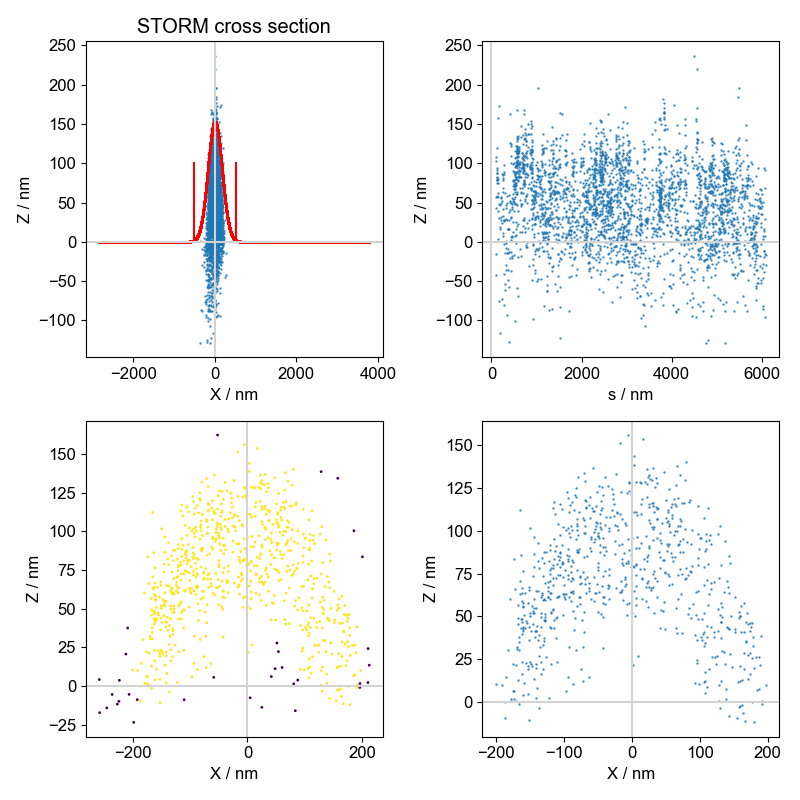

In [18]:
# Change the parameters by hand:
# N_filt = 1000
# LLR_filt = 200
# eps_filt = 10
# min_sample_filt = 5


# Run the script with one example defocus
locS = STORM_locs_list[0]
locS_c = locS.copy()

if fibril_nr == '4_3':
    locS_c = locS_c[locS_c['s'] > 1540]

# refining the STORM Data
locS_c = locS_c[locS_c['N']>N_filt]   
# locS_c = locS_c[locS_c['len']>len_filt]   
locS_c = locS_c[locS_c['LLR']<LLR_filt] 

locS_c = filt(locS_c,'X',c[1]-3*c[2],c[1]+3*c[2])
# # filtering left and right of the fibril using 3 σ
# # using the same cutoff as for the AFM Data



# STORM clustering
locS_c = locS_c.sort_values('X')
x_locS = locS_c.loc[:, ['X','Y']].values
dbscanS = DBSCAN(eps = eps_filt, 
                 min_samples = min_sample_filt).fit(x_locS) # fitting the model
labelsS = dbscanS.labels_# getting the labels
locS_c['cluster2']=labelsS
locS_c = locS_c[locS_c['cluster2']>=0]


# # # Merge the localisations
# displacement = 150 # default = 100
# memory = 5 # default = 5
# traj=tp.link(locS_c, displacement, memory=memory, pos_columns=['x', 'y'])
# locS_c=traj.groupby('particle').mean() # merge signals over frames
# locS_c['len']=traj.groupby('particle').apply(len) # how many frames does the signal prevail




fib_filtered, ax =plt.subplots(2,2,figsize=(8,8))
ax[0][0].scatter(locS['X'],locS['Y'], s=0.5, alpha=0.8)

# Plot histogram and fit
ax[0][0].scatter(x_values, fitfunc(c, x_values), c='red', label='Gauss fit',s=1)
ax[0][0].plot([c[1]-3*c[2],c[1]-3*c[2]],[0,100],c='r')
ax[0][0].plot([c[1]+3*c[2],c[1]+3*c[2]],[0,100],c='r')
ax[0][1].scatter(locS['s'],locS['Y'], s=0.5, alpha=0.8)
ax[1][0].scatter(x_locS[:, 0], x_locS[:,1], c = labelsS, s=1) # plotting the clusters
ax[1][1].scatter(locS_c['X'],locS_c['Y'], s=0.5, alpha=0.8)
cross(ax[0][0]), cross(ax[0][1]), cross(ax[1][0]), cross(ax[1][1])
ax[0][0].set_xlabel("X / nm"),ax[0][0].set_ylabel("Z / nm")
ax[0][0].set_title("STORM cross section")
ax[0][1].set_xlabel("s / nm"), ax[0][1].set_ylabel("Z / nm")
ax[1][0].set_xlabel("X / nm"),ax[1][0].set_ylabel("Z / nm")
ax[1][1].set_xlabel("X / nm"),ax[1][1].set_ylabel("Z / nm")

fib_filtered.tight_layout()
fib_filtered.savefig(results_folder+f'STORM_fib_filtered_{def_filter}.png',dpi=600)   
# save the figure to file
plt.show()

## Calculate the localisation precision

In [19]:
# displacement=150 # default = 100
# memory = 5 # default = 5

# traj=tp.link(locS_c, displacement, memory=memory, pos_columns=['x', 'y', 'z'])

# m_locs=traj.groupby('particle').mean() # merge signals over frames
# m_locs['len']=traj.groupby('particle').apply(len) # how many frames does the signal prevail

In [20]:
# m_locs['stdx']=traj['x'].groupby(traj['particle']).apply(np.std) 
# m_locs['stdy']=traj['y'].groupby(traj['particle']).apply(np.std)
# m_locs['stdz']=traj['z'].groupby(traj['particle']).apply(np.std)

# # Standard error of the mean:
# m_locs['SE_stdx']= m_locs['stdx']/np.sqrt(m_locs['len'])
# m_locs['SE_stdy']=m_locs['stdy']/np.sqrt(m_locs['len'])
# m_locs['SE_stdz']=m_locs['stdz']/np.sqrt(m_locs['len'])

# dx_loc=round(np.mean(m_locs['stdx'][m_locs['len']>1]),2) 
# dy_loc=round(np.mean(m_locs['stdy'][m_locs['len']>1]),2)
# dz_loc=round(np.mean(m_locs['stdz'][m_locs['len']>1]),2)

# SE_dx_loc=round(np.mean(m_locs['SE_stdx'][m_locs['len']>1]),2) 
# SE_dy_loc=round(np.mean(m_locs['SE_stdy'][m_locs['len']>1]),2)
# SE_dz_loc=round(np.mean(m_locs['SE_stdz'][m_locs['len']>1]),2)

# # Print the results:
# print(dx_loc,dy_loc,dz_loc)
# print(SE_dx_loc, SE_dy_loc, SE_dz_loc)

In [21]:
# m_locs_len = m_locs[m_locs['len']>1]

# fib_filtered, ax =plt.subplots(figsize=(8,8))
# s1 = ax.scatter(m_locs['X'],m_locs['Y'], s=20, alpha=0.8,c=m_locs['len'],cmap='viridis')
# s1 = ax.scatter(m_locs_len['X'],m_locs_len['Y'], c='r', alpha=0.8)
# plt.colorbar(s1)
# ax.set_xlabel("X / nm"),ax.set_ylabel("Z / nm")
# fib_filtered.tight_layout()
# plt.show()

## Determine the cross section height of the fibril 


-200.71 197.57


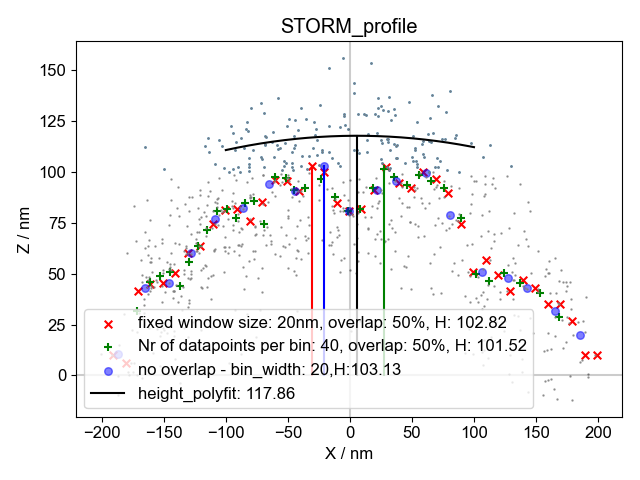

In [22]:
locS_c = locS_c.sort_values('X')

STORM_sw_H,x_max_sw,y_max_sw = sliding_win(locS_c,ws,overlap)
# sliding window fixed binning

STORM_sw_H_n,x_max_sw_n,y_max_sw_n = sliding_win_n(locS_c,40,overlap_n)
# sliding window binning datapoints

df_H,x_H_height,H_height = bin_data_by_x(locS_c,ws)
# binning with fixed binsize


upper_cutoff_poly = 100
x_fit,h_poly,x_u_fit,y_u_fit,S_D_u_half = calc_height_polynome(locS_c,upper_cutoff_poly)

# Plot the results:
fig,ax1 = plt.subplots()
# sliding window fixed binning
ax1.scatter(STORM_sw_H[0],STORM_sw_H[1],c='r',marker='x',
            label = f'fixed window size: {ws}nm, '+
            f'overlap: {int(overlap*100)}%, H: {round(y_max_sw,2)}',s=30)
ax1.plot([x_max_sw,x_max_sw],[0,y_max_sw],c='r')

# sliding window binning datapoints
ax1.scatter(STORM_sw_H_n[0],STORM_sw_H_n[1],c='g',marker='+',
            label = f'Nr of datapoints per bin: {n_ws},'+
            f' overlap: {int(overlap_n*100)}%, H: {round(y_max_sw_n,2)}',s=40)
ax1.plot([x_max_sw_n,x_max_sw_n],[0,y_max_sw_n],c='g')

# binning with fixed binsize
ax1.scatter(df_H['X'], df_H['Y'],
            color='b',label = f'no overlap - bin_width: {ws},'+
            f'H:{round(H_height,2)}',s=30,alpha=0.5) 
ax1.plot([x_H_height,x_H_height],[0,H_height],c='b')

# Plotting the polynome results
ax1.scatter(S_D_u_half['X'],S_D_u_half['Y'],s=0.8,alpha=0.9,c='C0') 
ax1.plot(x_u_fit,y_u_fit,color='black')
ax1.plot([x_fit,x_fit],[0,h_poly],color='black',
                label = f'height_polyfit: {round(h_poly,2)}')
    
# plotting the rest of the data
ax1.scatter(locS_c['X'],locS_c['Y'], s=0.5, alpha=0.8,c='grey')
ax1.set_xlabel("X / nm") # X-axis label
ax1.set_ylabel("Z / nm") # Y-axis label
# ax1.axis('equal')

ax1.set_title('STORM_profile')
ax1.axhline(color='k',alpha=0.2)
ax1.axvline(color='k',alpha=0.2)
ax1.legend()

# ax1.set_ylim(200,250)
# ax1.set_xlim(-220,220)

plt.tight_layout()
fig.savefig(results_folder+'STORM_topfit_binning.png',dpi=500)

In [23]:
len(locS_c)

747

In [24]:
## Determine the photon numbers of the top locs (that were used for the hiehgt determination)
locS_photon = locS_c.copy()

# Sort the DataFrame by x (important for meaningful selection)
df_sorted = locS_photon.sort_values(by='X')

# Get 20 values where x <= x_value
below_or_equal = df_sorted[df_sorted['X'] <= x_max_sw_n].tail(20)

# Get 20 values where x >= x_value
above = df_sorted[df_sorted['X'] > x_max_sw_n].head(20)

# Combine them if needed
df_selected = pd.concat([below_or_equal, above])



In [25]:
print('Whole profile')
print(len(locS_c))
print('sum N', np.sum(locS_c['N']))
print('sum bg',np.sum(locS_c['bg']))
print('SBR',np.round(np.sum(locS_c['N'])/np.sum(locS_c['bg'])))

print('\nmedian signal',np.median(locS_c['N']))
print('median bg',np.median(locS_c['bg']))
print('SBR_median',np.round(np.median(locS_c['N'])/np.median(locS_c['bg'])))



print('\nheight window containing 40 locs')
print(len(df_selected))
print('sum N', np.sum(df_selected['N']))
print('sum bg',np.sum(df_selected['bg']))
print('SBR',np.round(np.sum(df_selected['N'])/np.sum(df_selected['bg'])))

print('\nmedian signal',np.median(df_selected['N']))
print('median bg',np.median(df_selected['bg']))
print('SBR_median',np.round(np.median(df_selected['N'])/np.median(df_selected['bg'])))

Whole profile
747
sum N 2505482.4084
sum bg 20909.181992
SBR 120.0

median signal 3053.7434
median bg 27.85506
SBR_median 110.0

height window containing 40 locs
40
sum N 123648.2604
sum bg 1119.772069
SBR 110.0

median signal 2903.8207
median bg 28.0378865
SBR_median 104.0


Text(0, 0.5, 'signal photon numbers')

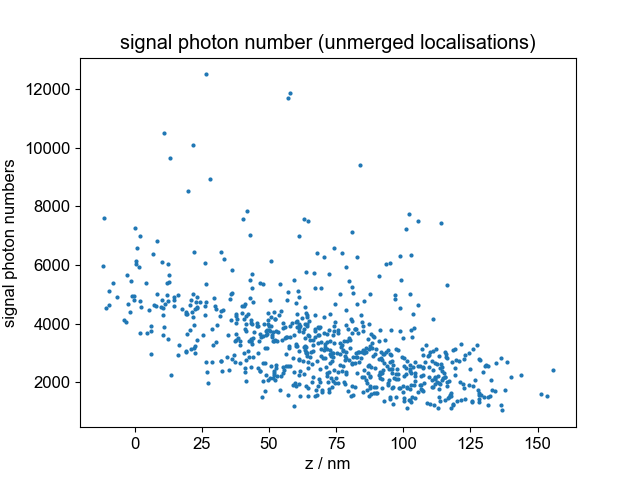

In [27]:
fig,ax = plt.subplots()
ax.scatter(locS_c['Y'],locS_c['N'],s=4)
ax.set_title('signal photon number (unmerged localisations)')
ax.set_xlabel('z / nm')
ax.set_ylabel('signal photon numbers')

Text(0, 0.5, 'bg')

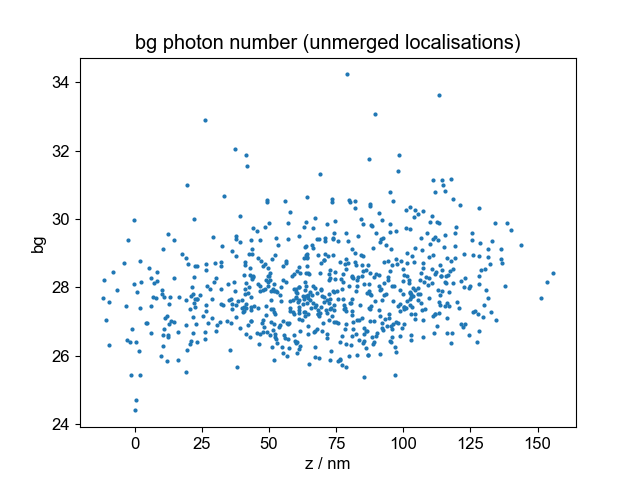

In [28]:
fig,ax = plt.subplots()
ax.scatter(locS_c['Y'],locS_c['bg'],s=4)
ax.set_title('bg photon number (unmerged localisations)')
ax.set_xlabel('z / nm')
ax.set_ylabel('bg')

## Estimate the error of the height measurement:

Text(0, 0.5, 'counts')

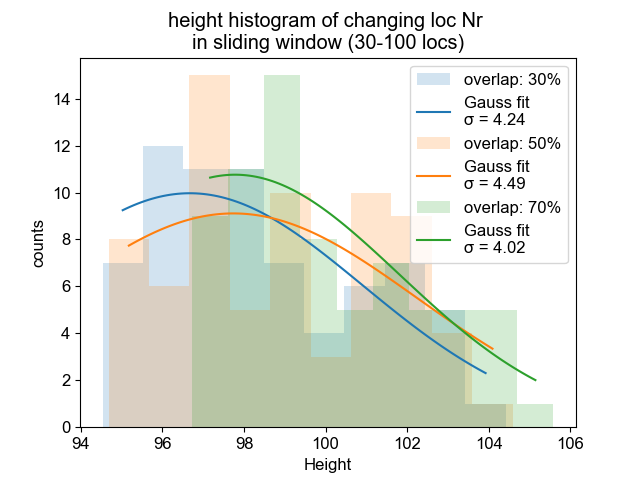

In [30]:
# Vary the number of locs in the window
bin_range = np.linspace(30,100,71)
bin_range = [int(j) for j in bin_range]
over = [0.3,0.5,0.7]
colors_gauss = ['C0','C1','C2']
ci = 0

fig,ax = plt.subplots()
for ov in over:
    df = []
    for k in bin_range:
        STORM_sw_H_n,x_max_sw_n,y_max_sw_n = sliding_win_n(locS_c,k,ov)
        df += [y_max_sw_n]
    
    h = ax.hist(df,label = f'overlap: {int(ov*100)}%',alpha=0.2,color=colors_gauss[ci])

    h_x = (h[1][:-1] + h[1][1:]) / 2
    h_y = h[0]
    
    # Gaussian fit
    fitfunc = lambda p, x: p[0] * np.exp(-0.5 * ((x - p[1]) / p[2])**2)
    errfunc = lambda p, x, y: y - fitfunc(p, x)
    params, _ = leastsq(errfunc, [10.0, y_max_sw_n, 3], args=(h_x,h_y))
    d = [round(p, 2) for p in params]
    
    x_val = np.linspace(min(h_x),max(h_x),100)
    ax.plot(x_val, fitfunc(d, x_val),
            label=f'Gauss fit\nσ = {d[2]}',
            color=colors_gauss[ci])
    ci +=1
ax.legend()
ax.set_title('height histogram of changing loc Nr \nin sliding window (30-100 locs)')
ax.set_xlabel('Height')
ax.set_ylabel('counts')

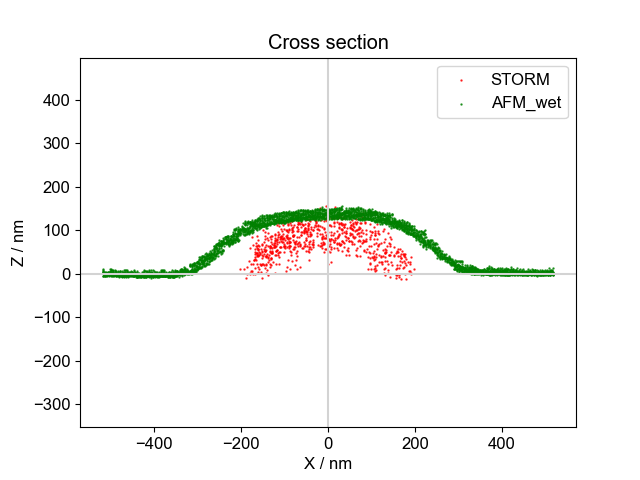

In [31]:
# plot the filtered data:
figure_cross_section_combined, ax1=plt.subplots()
ax1.scatter(locS_c['X'],locS_c['Y'], s=0.5, alpha=0.8,color='red',label='STORM') 
ax1.scatter(locW_c['X'],locW_c['Y'], s=0.5, alpha=0.8,color='green',label='AFM_wet')
# ax1.scatter(AFM_Data_wet_c['X'],AFM_Data_wet_c['Y'], s=0.5, alpha=0.8,color='blue',label='AFM_wet')
cross(ax1), ax1.set_xlabel("X / nm"), ax1.set_ylabel("Z / nm")
ax1.axis('equal'), ax1.legend(), ax1.set_title("Cross section")  
figure_cross_section_combined.savefig(results_folder+f'figure_cross_section_combined_{def_filter}.png',dpi=600)   

# Find the right RI-value for one fibril

In [ ]:
# Note that we calculated two different error estimations for the refractive index
# Bootstrap: The RI was determined several times using the same amount of locs as in the
# original profile but randomly selected (also allowing double selecting)

# Resampling: The RI was determined several times using the half of the amount of locs 
# as in the original profile randomly selected (not allowing for double selecting)

# For the final results, the resampling method has been selected for the error estimation 

In [32]:
# Save all the filter parameters used before:
filter_para = {'ROI': ROI,'fibril': fibril,
               'eps_AFM':eps_AFM, 'min_AFM':min_AFM,'N_filt':N_filt, 'LLR_filt':LLR_filt,
               'eps_filt':eps_filt, 'min_sample_filt':min_sample_filt, 
               'ws':ws, 'overlap':overlap, 'n_ws':n_ws, 
               'overlap_n':overlap_n, 'def_filter':def_filter}  

0 % done
12 % done
25 % done
37 % done
50 % done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_39490/329578668.py:238: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_STORM_cross_section_topfit, ax1=plt.subplots()


62 % done
75 % done
87 % done


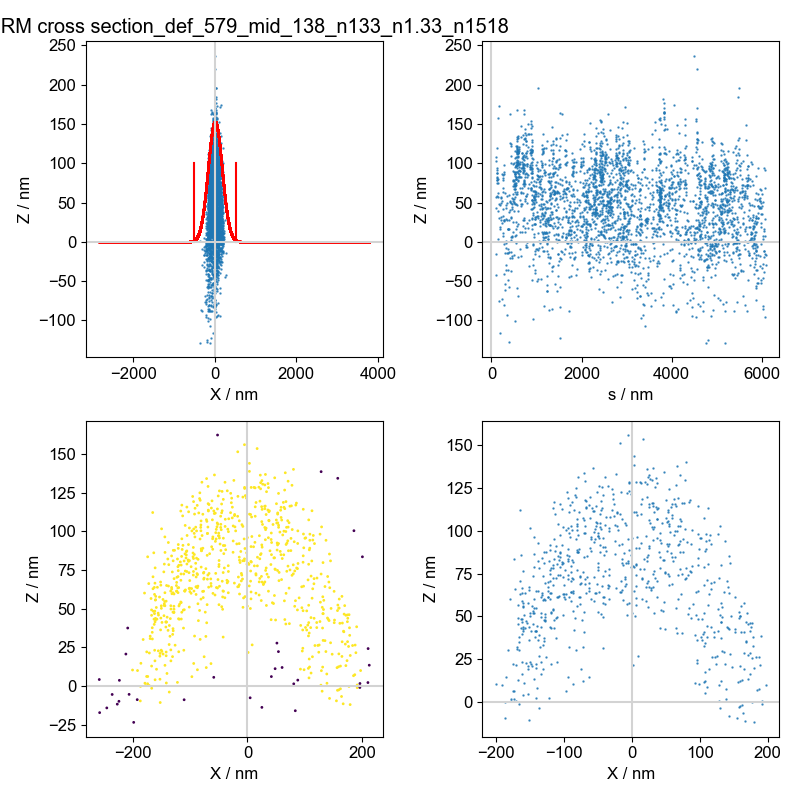

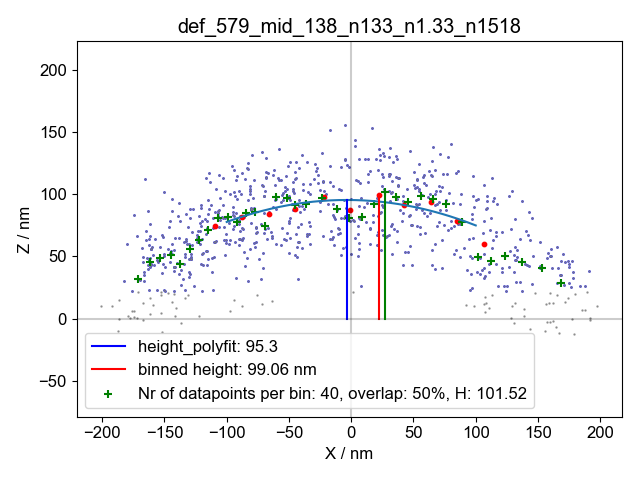

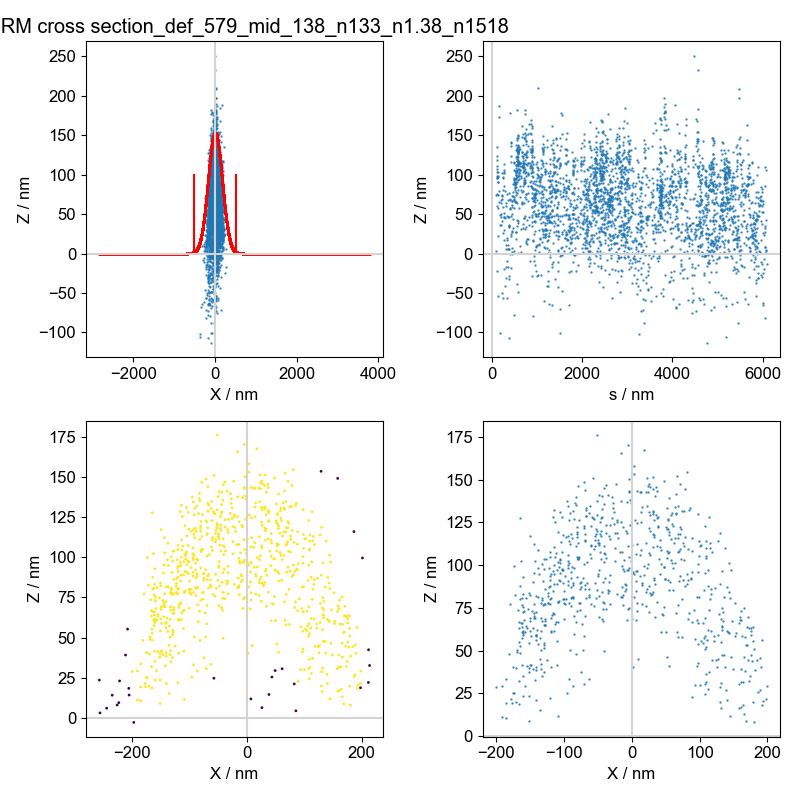

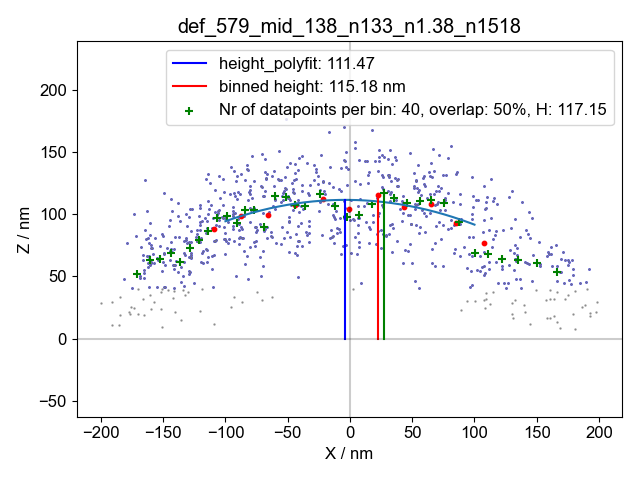

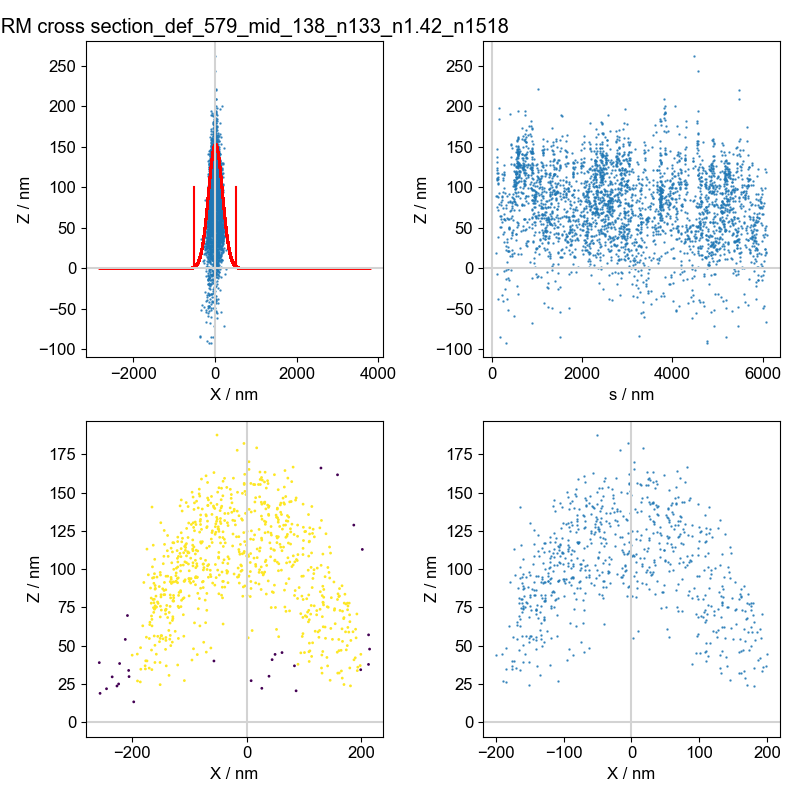

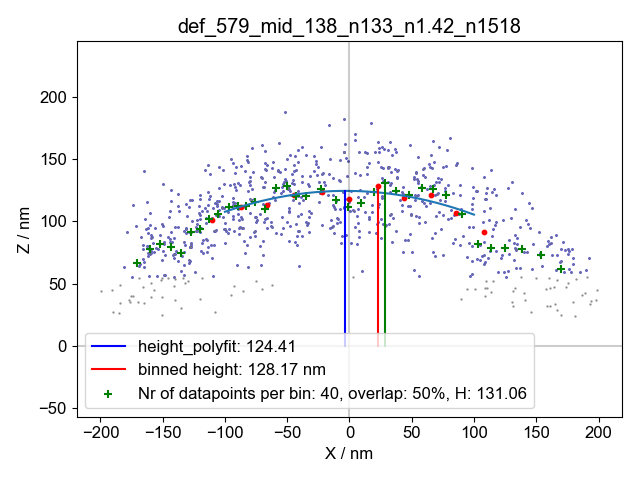

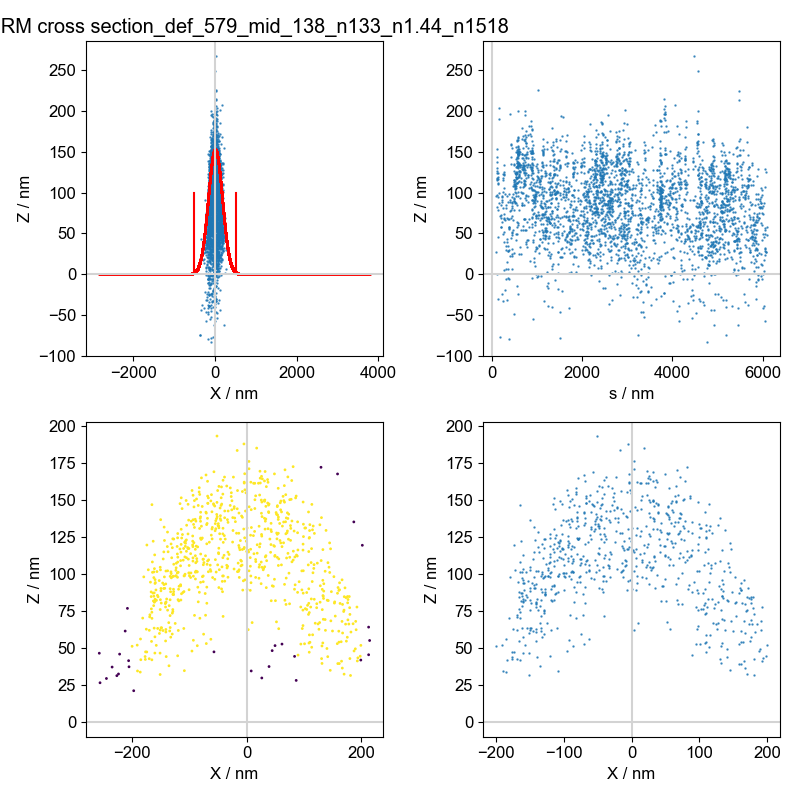

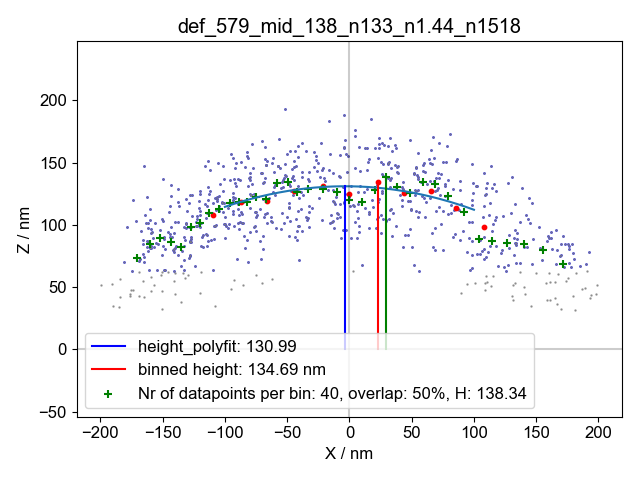

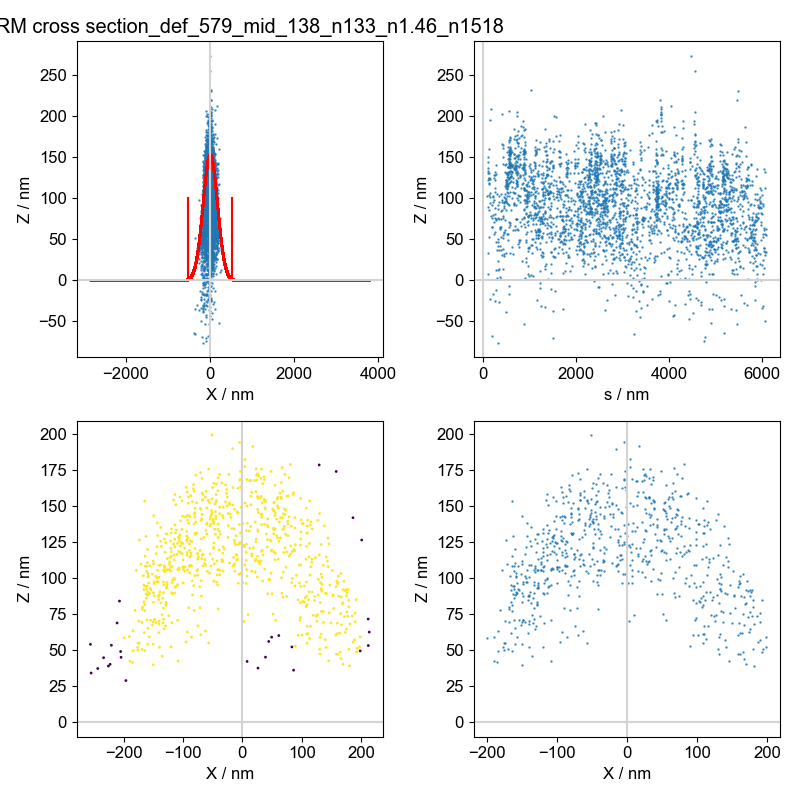

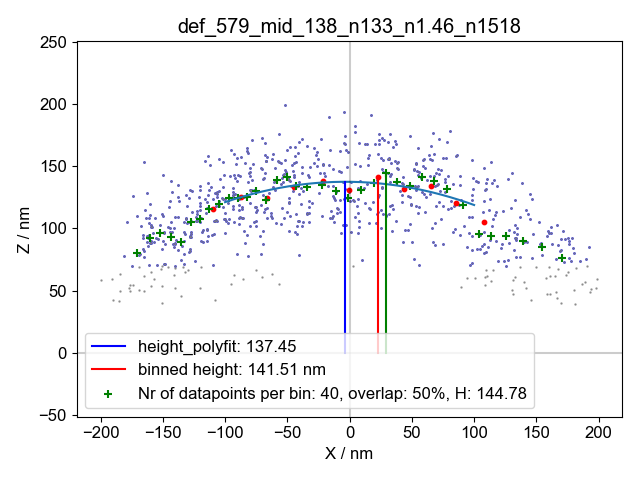

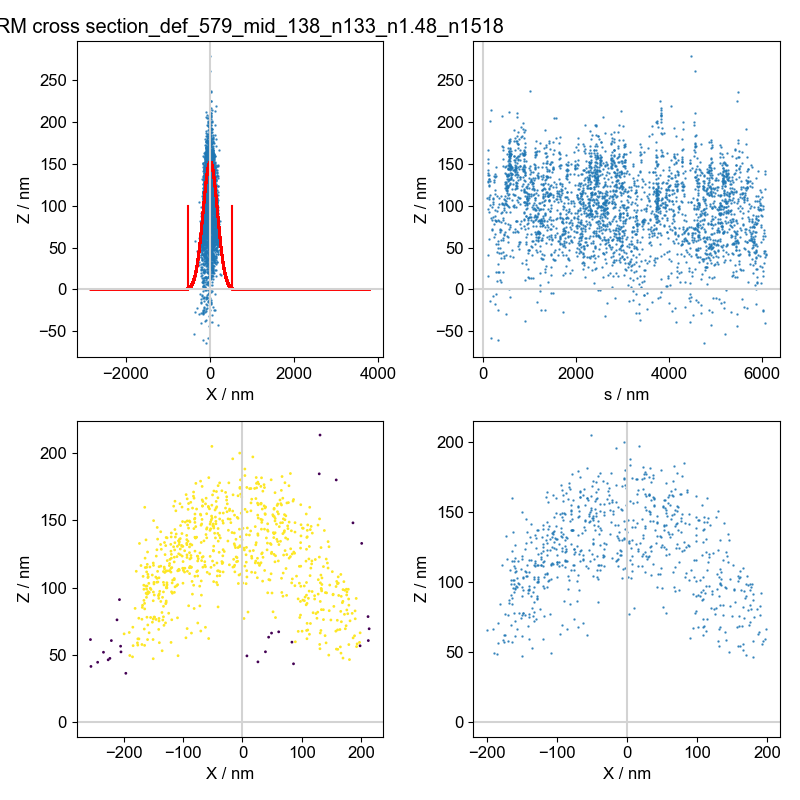

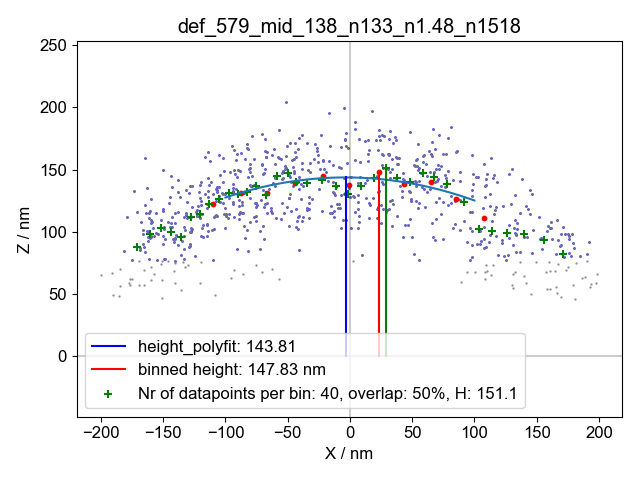

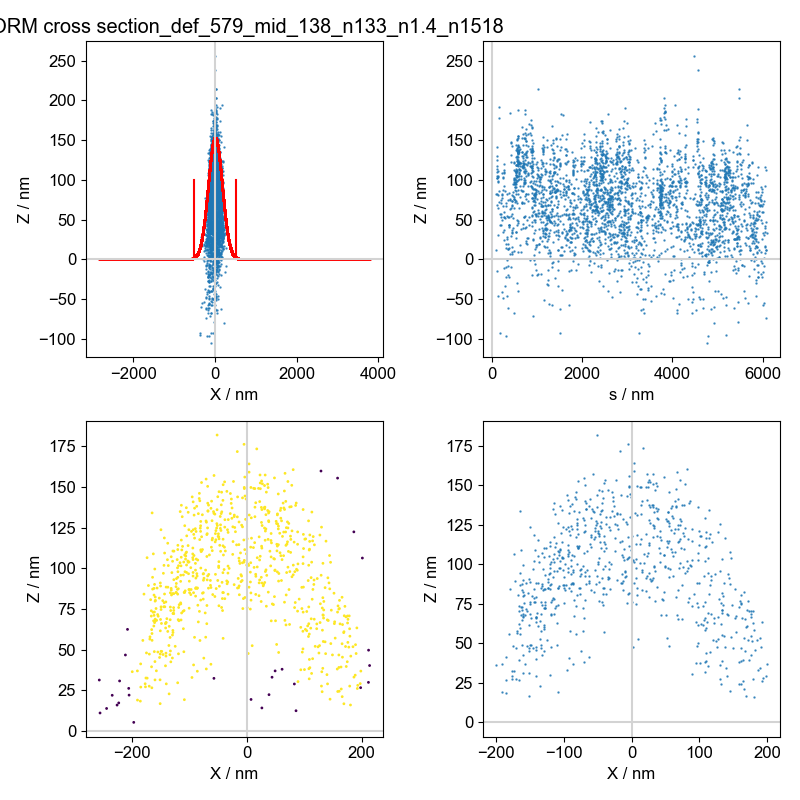

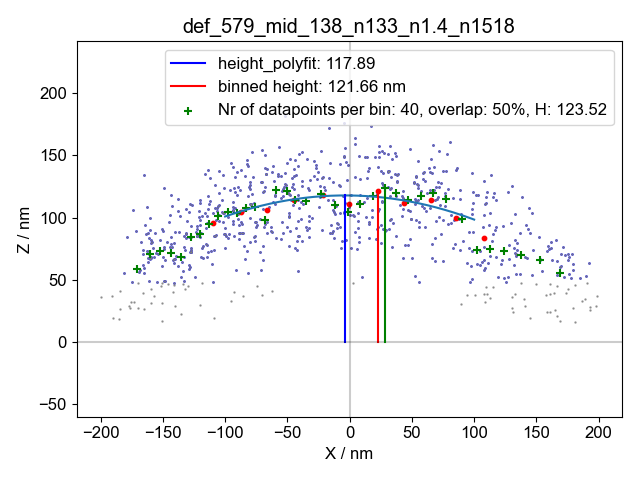

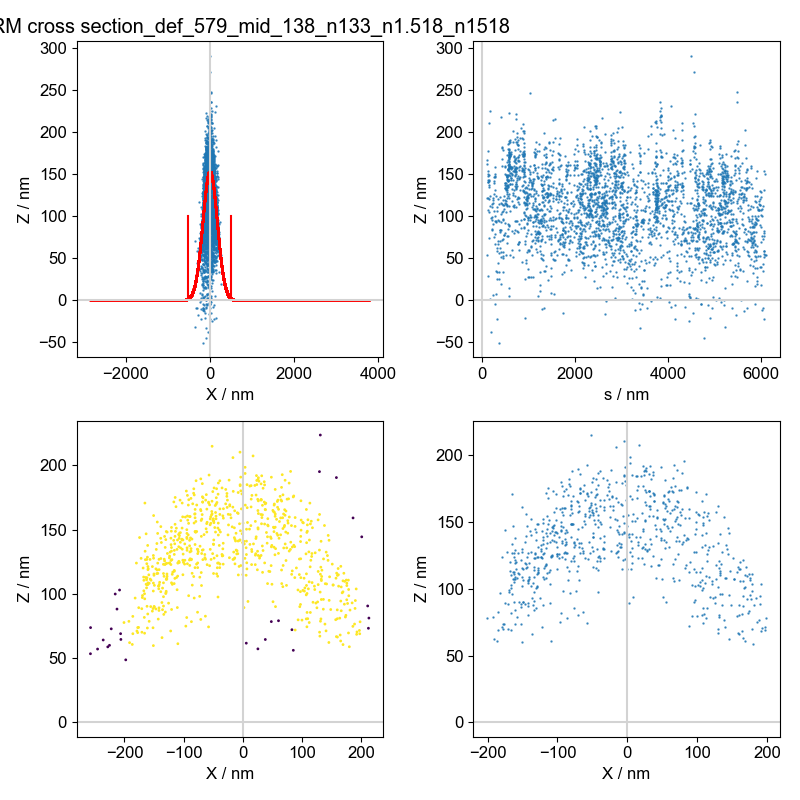

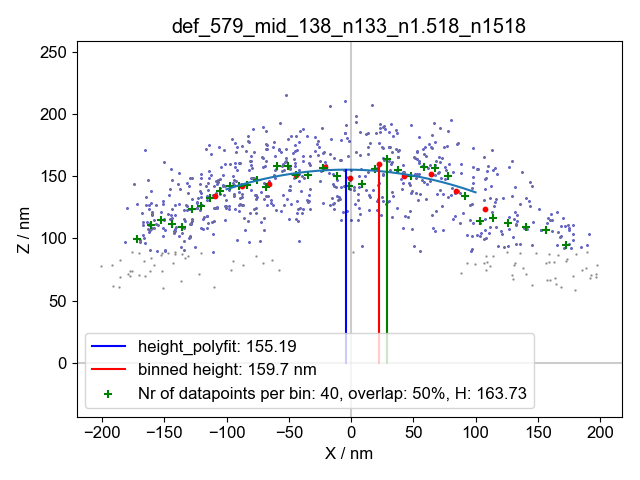

In [33]:
## Run the script for one defocus value
STORM_locs_list = STORM_locs_list_defFILT
STORM_defocus_list = STORM_def_list_defFILT


for j in range(len(STORM_locs_list)):  
    print(int(j/len(STORM_locs_list)*100),'% done')
    def_para = STORM_defocus_list[j]
    defocus = def_para.split('_n')[0]
    refractive_index = def_para.split('_n')[2]
    refractive_index = int(float(refractive_index)*100)
    
    locS = STORM_locs_list[j]
    locS_c = locS.copy()
    
#     if fibril_nr == '4_3':
#         locS_c = locS_c[locS_c['s'] > 1540] 
#     # This line above is fibril specific and may not be used for the analysis of all fibrils !
        
        
    # refining the STORM Data
    locS_c = locS_c[locS_c['N']>N_filt]   
#     locS_c = locS_c[locS_c['len']>len_filt]   
    locS_c = locS_c[locS_c['LLR']<LLR_filt] 
    locS_c = filt(locS_c,'X',c[1]-3*c[2],c[1]+3*c[2])
    # filtering left and right of the fibril using 3 σ
    # using the same cutoff as for the AFM Data



    # STORM clustering
    locS_c = locS_c.sort_values('X')
    ## Cleaning up the AFM fibril by using the DBSCAN clustering algorithmus
    x_locS = locS_c.loc[:, ['X','Y']].values
    dbscanS = DBSCAN(eps = eps_filt, 
                     min_samples = min_sample_filt).fit(x_locS) # fitting the model
    labelsS = dbscanS.labels_# getting the labels
    locS_c['cluster2']=labelsS
    locS_c = locS_c[locS_c['cluster2']>=0]

    fib_filtered, ax =plt.subplots(2,2,figsize=(8,8))
    ax[0][0].scatter(locS['X'],locS['Y'], s=0.5, alpha=0.8)

    # Plot histogram and fit
    ax[0][0].scatter(x_values, fitfunc(c, x_values), c='red', label='Gauss fit',s=1)
    ax[0][0].plot([c[1]-3*c[2],c[1]-3*c[2]],[0,100],c='r')
    ax[0][0].plot([c[1]+3*c[2],c[1]+3*c[2]],[0,100],c='r')
    ax[0][1].scatter(locS['s'],locS['Y'], s=0.5, alpha=0.8)
    ax[1][0].scatter(x_locS[:, 0], x_locS[:,1], c = labelsS, s=1) # plotting the clusters
    ax[1][1].scatter(locS_c['X'],locS_c['Y'], s=0.5, alpha=0.8)
    cross(ax[0][0]), cross(ax[0][1]), cross(ax[1][0]), cross(ax[1][1])
    ax[0][0].set_xlabel("X / nm"),ax[0][0].set_ylabel("Z / nm")
    ax[0][0].set_title(f"STORM cross section_{def_para}")
    ax[0][1].set_xlabel("s / nm"), ax[0][1].set_ylabel("Z / nm")
    ax[1][0].set_xlabel("X / nm"),ax[1][0].set_ylabel("Z / nm")
    ax[1][1].set_xlabel("X / nm"),ax[1][1].set_ylabel("Z / nm")

    fib_filtered.tight_layout()
    fib_filtered.savefig(results_folder+f'STORM_fib_filtered_{def_para}.png',dpi=600)   
    # save the figure to file

    

    # Calculate the heights alternatively:
    upper_cutoff_poly = locS_c.copy()
    upper_cutoff_poly = filt(upper_cutoff_poly,'X',-10,10)
    upper_cutoff_poly = min(upper_cutoff_poly['Y'])
    H_p,H_b,Hbn,STORM_Data_upper_half = calc_height(locS_c,upper_cutoff_poly,
                                                    def_para=def_para)

    # The median bg height of the AFM results is added:
    H_p = H_p + bg_side_median
    H_b = H_b + bg_side_median
    Hbn = Hbn + bg_side_median
    
    # Median LLR
    median_LLR = np.median(STORM_Data_upper_half['LLR'])
    
    er_h_b,m_b,sdt_b,er_h_r,m_r,sdt_r = calc_error(locS_c,n_ws,overlap_n)
   
    # Create a dictionary for the new row
    new_row = {'defocus':defocus,'refractive_index': refractive_index,
               'H_AFM_W': W_AFM_fib_height,
               'H_polyfit': H_p,'H_bin': H_b,
               'sliding_window_height':Hbn,
               'LLR':median_LLR,
               'er_h_b':er_h_b,'m_b':m_b,'sdt_b':sdt_b,
               'er_h_r':er_h_r,'m_r':m_r,'sdt_r':sdt_r}
    
    ## Merge the filtration data with the results data:
    new_row.update(filter_para)
    
    # Convert the dictionary to a DataFrame and concatenate it to H_df
    result_list = pd.concat([result_list, pd.DataFrame([new_row])], ignore_index=True)
    
    
    # Save the current STORM profile:
    locS_c.to_csv(results_folder+f'Data_n_STORM_ROI_{ROI}_fib_{fibril_nr}_def_{defocus}_n_{refractive_index}.csv')
    
with open(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_result_list.pkl','wb') as file:
    pickle.dump(result_list, file)

In [34]:
# Remove identical rows
df_res = result_list.copy()
df_res['refractive_index'] = df_res['refractive_index'].apply(lambda x: int(x))
df_res = df_res.drop_duplicates(subset=['ROI','fibril','defocus',
                                        'refractive_index'], keep='last')
df_res = df_res.sort_values('refractive_index')


# Choose which height measuring method you would like to take
H_AFM_compare = df_res['H_AFM_W'].iloc[1][1]
# df_res = df_res[df_res['refractive_index']>133]

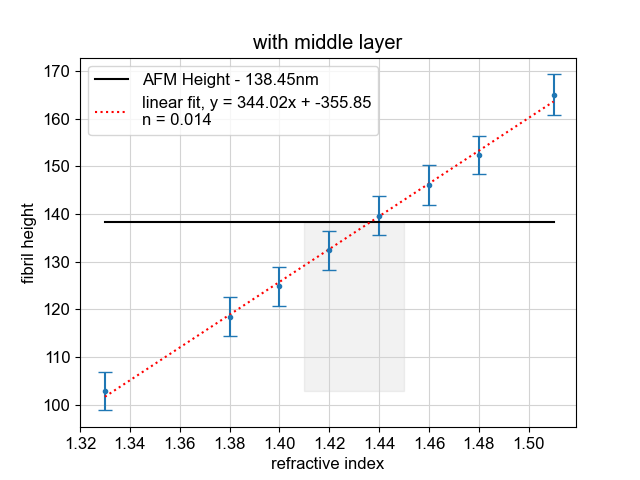

In [35]:
# make a list of all defocus values in the datatable:
defocus_used_list = list(set(df_res['defocus']))
defocus_used_list.sort()


errorbars = df_res['sdt_b']

fig,ax = plt.subplots()
for index,k in enumerate(defocus_used_list):
    df_plot = df_res[df_res['defocus'] == k]
    df_plot['refractive_index'] = df_plot['refractive_index']/100
#     ax.scatter(df_plot['refractive_index'],df_plot['sliding_window_height'],
#     c='C'+f'{index}',label=f'defocus {k}')
    ax.errorbar(df_plot['refractive_index'],df_plot['sliding_window_height'],
                errorbars,fmt ='o',capsize=5,markersize=3)

    
# make a linear fit through the datapoints:
x_fit = df_plot['refractive_index']
y_fit = df_plot['sliding_window_height']
fit_p = np.polyfit(x_fit,y_fit,1)
x_n = np.linspace(min(x_fit),max(x_fit),100)
y_n = np.polyval(fit_p,x_n)

# just for better visualisation
fit_p = [round(j,2) for j in fit_p]

# Calculate the intersection:
x_intersect = (H_AFM_compare-fit_p[1])/fit_p[0]
n_intersect = round(x_intersect/100,3)

ax.set_xlabel('refractive index')
ax.set_ylabel('fibril height')
ax.plot([min(df_res['refractive_index']/100),max(df_res['refractive_index']/100)],
        [H_AFM_compare,H_AFM_compare],c='k',
        label=f'AFM Height - {H_AFM_compare}nm')

# ax.axhline(0,label='0 - line',c='grey')
# ax.plot([min(df['refractive_index']),max(df['refractive_index'])],
#         [150,150],c='g',linestyle = '--',label='AFM Height expected')
ax.plot(x_n,y_n,label=f'linear fit, y = {fit_p[0]}x + {fit_p[1]}\nn = {n_intersect}',
        color = 'r',linestyle=':')

ax.fill_between(x=[1.41,1.45],y1=H_AFM_compare,
                y2 = min(y_fit),color='grey',alpha=0.1)

ax.grid()
ax.legend()
ax.set_title('with middle layer')
ax.grid(color='lightgrey')
ax.set_xticks(np.linspace(1.32,1.50,10))
fig.savefig(results_folder+f'overview_height_result_ROI_{ROI}_fibril_{fibril_nr}.png',dpi=600)
plt.show()

In [36]:
df_res

ROI      fibril  refractive_index          defocus eps_AFM min_AFM  \
96   2_1_2  fibril_4_2               133  def_579_mid_138       5       7   
97   2_1_2  fibril_4_2               138  def_579_mid_138       5       7   
102  2_1_2  fibril_4_2               140  def_579_mid_138       5       7   
98   2_1_2  fibril_4_2               142  def_579_mid_138       5       7   
99   2_1_2  fibril_4_2               144  def_579_mid_138       5       7   
100  2_1_2  fibril_4_2               146  def_579_mid_138       5       7   
101  2_1_2  fibril_4_2               148  def_579_mid_138       5       7   
103  2_1_2  fibril_4_2               151  def_579_mid_138       5       7   

    N_filt LLR_filt eps_filt min_sample_filt  ...   H_bin  \
96    1000      160       36              60  ...  100.40   
97    1000      160       36              60  ...  116.52   
102   1000      160       36              60  ...  123.00   
98    1000      160       36              60  ...  129.51   
99    1000      160       36              60  ...  136.03   
100   1000      160       36              60  ...  142.85   
101   1000      160       36              60  ...  149.17   
103   1000      160       36              60  ...  161.04   

     sliding_window_height         LLR  locS_c  \
96                 102.855  143.196095     NaN   
97                 118.490  143.344955     NaN   
102                124.860  143.286135     NaN   
98                 132.400  143.306610     NaN   
99                 139.685  143.417300     NaN   
100                146.115  143.575560     NaN   
101                152.440  143.524175     NaN   
103                165.070  143.584820     NaN   

                                                er_h_b         m_b     sdt_b  \
96   [103.41499999999999, 102.82, 104.42, 106.21, 1...  105.717014  4.020956   
97   [120.86, 117.15, 124.21, 121.85, 129.1, 120.86...  121.808005  4.050798   
102  [124.445, 125.265, 128.39499999999998, 123.065...  128.162367  4.118485   
98   [130.29500000000002, 129.595, 135.13, 138.0, 1...  134.596396  4.087389   
99   [141.765, 146.26, 136.5, 144.95, 138.91, 148.6...  141.028589  4.043301   
100  [142.49, 152.515, 143.27499999999998, 156.1, 1...  147.601487  4.178881   
101  [152.44, 153.17000000000002, 145.86, 149.56, 1...  153.800024  4.055591   
103  [172.74, 161.84, 170.5, 162.21, 168.97, 162.90...  165.951813  4.243598   

                                                er_h_r         m_r     sdt_r  
96   [99.815, 96.15, 95.68, 98.82499999999999, 93.7...   99.684560  3.145901  
97   [118.155, 112.31, 112.155, 117.49, 116.26, 118...  115.809500  3.067027  
102  [118.845, 125.49000000000001, 123.039999999999...  121.831720  3.091861  
98   [127.685, 125.14500000000001, 133.6, 126.14500...  128.375760  3.186902  
99   [132.07999999999998, 136.26999999999998, 133.7...  134.987955  3.130903  
100  [140.485, 143.485, 141.34, 140.255, 141.269999...  141.373410  3.095694  
101  [147.82999999999998, 148.88, 144.27, 145.17000...  147.711230  3.125862  
103  [160.5, 161.71, 156.77999999999997, 159.095, 1...  159.576975  3.148724  

[8 rows x 27 columns]

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_39490/3394924790.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


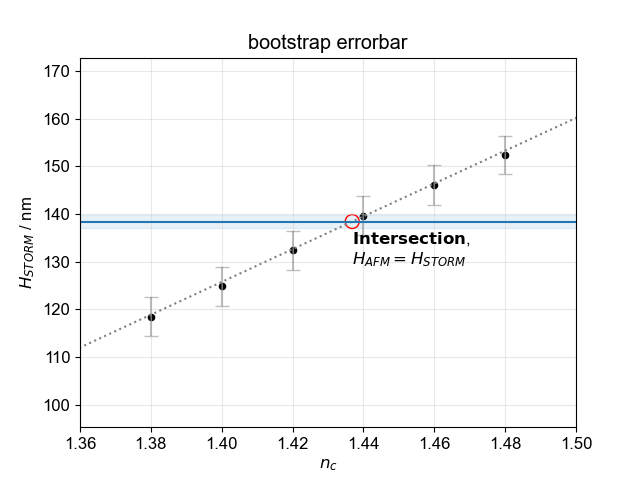

In [37]:
# make a list of all defocus values in the datatable:
defocus_used_list = list(set(df_res['defocus']))
defocus_used_list.sort()
df_plot = df_res.copy()
# Calculate the intersection:
x_intersect = (H_AFM_compare-fit_p[1])/fit_p[0]
n_intersect = round(x_intersect,3)

# Add the errorbars for the STORM data:
errorbars_STORM = df_plot['sdt_b']

# Add errorbars for the AFM Data:
with open(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_AFM_error.pkl','rb') as file:
    AFM_error = pickle.load(file)
    
errorbars_AFM = AFM_error['sdt_b']


fig,ax = plt.subplots()
# Plot the datapoints
ax.errorbar(df_plot['refractive_index']/100,df_plot['sliding_window_height'],
            errorbars_STORM,fmt ='None',capsize=5,color='grey',alpha = 0.5)
ax.scatter(df_plot['refractive_index']/100,df_plot['sliding_window_height'],
           color = 'k',label = 'Datapoints',s=20)
# ax.text(1.4,121,r"$\bf{H_{STORM} (n_c)}$")


# Plot the linear fit
ax.plot(x_n,y_n,label = 'linear fit, \n$H_{STORM}$ = '+f'{int(fit_p[0])}$n_c$ {int(fit_p[1])}',
        color = 'grey',linestyle=':')
# ax.text(1.365,107.5,r"$\bf{Linear}"+r"\: \bf{Fit}$"+
#         '\n$H_{STORM}$ = '+f'{int(fit_p[0])}·$n_c$ {int(fit_p[1])}')

# Plot the AFM Height Line
ax.plot([min(df_res['refractive_index']/100),max(df_res['refractive_index']/100)],
        [H_AFM_compare,H_AFM_compare],c='C0', linestyle = '-')

ax.fill_between([min(df_res['refractive_index']/100),max(df_res['refractive_index']/100)],
                H_AFM_compare-errorbars_AFM,H_AFM_compare+errorbars_AFM,
                color='C0',alpha = 0.1)
# ax.text(1.38,140,r'$\bf{H_{AFM}}$')# '+f'({int(H_AFM_compare)} nm)')

# Plot the intersection
ax.scatter(x_intersect,H_AFM_compare,s = 100,
           color = 'r',facecolors='none',edgecolor = 'r',
           label = 'Intersection, \n$H_{AFM} = H_{STORM}$')
#     f'\nn = {n_intersect}')
ax.text(x_intersect,H_AFM_compare-9,r'$\bf{Intersection}$,'+'\n$H_{AFM} = H_{STORM}$')
#     f'\nn = {n_intersect}')

ax.grid(color='lightgrey',alpha = 0.5)
ax.set_xlabel('$n_c$')
ax.set_ylabel('$H_{STORM}$ / nm')


# ax.legend(loc = 'lower right')
ax.set_xticks(np.linspace(1.32,1.50,10))
ax.set_xlim(1.36,1.5)
# ax.set_ylim(100,160)
ax.set_title('bootstrap errorbar')

fig.savefig(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_pretty_intersection_boot.png',dpi=600)
plt.tight_layout()
plt.show()

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_39490/3687182226.py:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


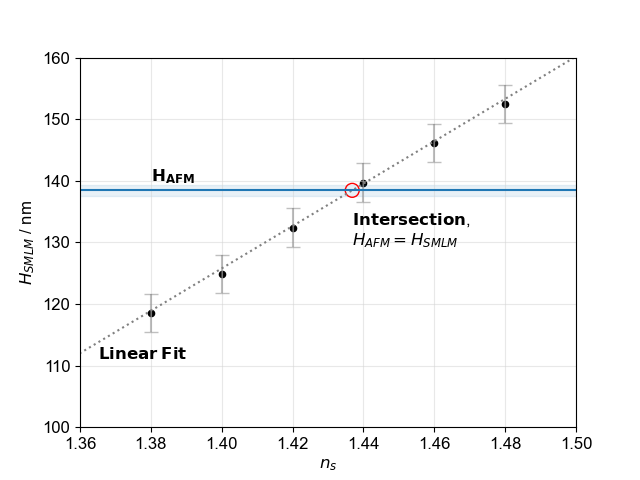

In [47]:
# make a list of all defocus values in the datatable:
defocus_used_list = list(set(df_res['defocus']))
defocus_used_list.sort()
df_plot = df_res.copy()
# Calculate the intersection:
x_intersect = (H_AFM_compare-fit_p[1])/fit_p[0]
n_intersect = round(x_intersect,3)

# Add the errorbars for the STORM data:
errorbars_STORM = df_plot['sdt_r']

# Add errorbars for the AFM Data:
with open(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_AFM_error.pkl','rb') as file:
    AFM_error = pickle.load(file)
    
errorbars_AFM = AFM_error['sdt_r']


fig,ax = plt.subplots()
# Plot the datapoints
ax.errorbar(df_plot['refractive_index']/100,df_plot['sliding_window_height'],
            errorbars_STORM,fmt ='None',capsize=5,color='grey',alpha = 0.5)
ax.scatter(df_plot['refractive_index']/100,df_plot['sliding_window_height'],
           color = 'k',label = 'Datapoints',s=20)
# ax.text(1.4,121,r"$\bf{H_{STORM} (n_c)}$")


# Plot the linear fit
ax.plot(x_n,y_n,label = 'linear fit, \n$H_{STORM}$ = '+f'{int(fit_p[0])}$n_c$ {int(fit_p[1])}',
        color = 'grey',linestyle=':')
ax.text(1.365,111,r"$\bf{Linear}"+r"\: \bf{Fit}$")

#         '\n$H_{SMLM}$ = '+f'{int(fit_p[0])}·$n$ {int(fit_p[1])}')

# Plot the AFM Height Line
ax.plot([min(df_res['refractive_index']/100),max(df_res['refractive_index']/100)],
        [H_AFM_compare,H_AFM_compare],c='C0', linestyle = '-')

ax.fill_between([min(df_res['refractive_index']/100),max(df_res['refractive_index']/100)],
                H_AFM_compare-errorbars_AFM,H_AFM_compare+errorbars_AFM,
                color='C0',alpha = 0.1)
ax.text(1.38,140,r'$\bf{H_{AFM}}$')# '+f'({int(H_AFM_compare)} nm)')

# Plot the intersection
ax.scatter(x_intersect,H_AFM_compare,s = 100,
           color = 'r',facecolors='none',edgecolor = 'r',
           label = 'Intersection \n$H_{AFM} = H_{SMLM}$')
#     f'\nn = {n_intersect}')
ax.text(x_intersect,H_AFM_compare-9,r'$\bf{Intersection}$,'+'\n$H_{AFM} = H_{SMLM}$')
#     f'\nn = {n_intersect}')

ax.grid(color='lightgrey',alpha = 0.5)
ax.set_xlabel('$n_s$')
ax.set_ylabel('$H_{SMLM}$ / nm')


# ax.legend(loc = 'lower right')
ax.set_xticks(np.linspace(1.32,1.50,10))
ax.set_xlim(1.36,1.5)
ax.set_ylim(100,160)
# ax.set_title('resampling errorbar')

fig.savefig(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_pretty_intersection_resample.png',
            dpi=600)
plt.tight_layout()
plt.show()

## Visualize the error for n

In [39]:
# Take random values for AFM height and 
# for STORM heights to estimate the error for n

# Choose the values according to their distributions earlier calculated !

In [40]:
df_plot

ROI      fibril  refractive_index          defocus eps_AFM min_AFM  \
96   2_1_2  fibril_4_2               133  def_579_mid_138       5       7   
97   2_1_2  fibril_4_2               138  def_579_mid_138       5       7   
102  2_1_2  fibril_4_2               140  def_579_mid_138       5       7   
98   2_1_2  fibril_4_2               142  def_579_mid_138       5       7   
99   2_1_2  fibril_4_2               144  def_579_mid_138       5       7   
100  2_1_2  fibril_4_2               146  def_579_mid_138       5       7   
101  2_1_2  fibril_4_2               148  def_579_mid_138       5       7   
103  2_1_2  fibril_4_2               151  def_579_mid_138       5       7   

    N_filt LLR_filt eps_filt min_sample_filt  ...   H_bin  \
96    1000      160       36              60  ...  100.40   
97    1000      160       36              60  ...  116.52   
102   1000      160       36              60  ...  123.00   
98    1000      160       36              60  ...  129.51   
99    1000      160       36              60  ...  136.03   
100   1000      160       36              60  ...  142.85   
101   1000      160       36              60  ...  149.17   
103   1000      160       36              60  ...  161.04   

     sliding_window_height         LLR  locS_c  \
96                 102.855  143.196095     NaN   
97                 118.490  143.344955     NaN   
102                124.860  143.286135     NaN   
98                 132.400  143.306610     NaN   
99                 139.685  143.417300     NaN   
100                146.115  143.575560     NaN   
101                152.440  143.524175     NaN   
103                165.070  143.584820     NaN   

                                                er_h_b         m_b     sdt_b  \
96   [103.41499999999999, 102.82, 104.42, 106.21, 1...  105.717014  4.020956   
97   [120.86, 117.15, 124.21, 121.85, 129.1, 120.86...  121.808005  4.050798   
102  [124.445, 125.265, 128.39499999999998, 123.065...  128.162367  4.118485   
98   [130.29500000000002, 129.595, 135.13, 138.0, 1...  134.596396  4.087389   
99   [141.765, 146.26, 136.5, 144.95, 138.91, 148.6...  141.028589  4.043301   
100  [142.49, 152.515, 143.27499999999998, 156.1, 1...  147.601487  4.178881   
101  [152.44, 153.17000000000002, 145.86, 149.56, 1...  153.800024  4.055591   
103  [172.74, 161.84, 170.5, 162.21, 168.97, 162.90...  165.951813  4.243598   

                                                er_h_r         m_r     sdt_r  
96   [99.815, 96.15, 95.68, 98.82499999999999, 93.7...   99.684560  3.145901  
97   [118.155, 112.31, 112.155, 117.49, 116.26, 118...  115.809500  3.067027  
102  [118.845, 125.49000000000001, 123.039999999999...  121.831720  3.091861  
98   [127.685, 125.14500000000001, 133.6, 126.14500...  128.375760  3.186902  
99   [132.07999999999998, 136.26999999999998, 133.7...  134.987955  3.130903  
100  [140.485, 143.485, 141.34, 140.255, 141.269999...  141.373410  3.095694  
101  [147.82999999999998, 148.88, 144.27, 145.17000...  147.711230  3.125862  
103  [160.5, 161.71, 156.77999999999997, 159.095, 1...  159.576975  3.148724  

[8 rows x 27 columns]

In [41]:
STORM_H = list(df_plot['sliding_window_height'])
method = ['r','b']
# b for bootstrap
# r for resampling

for meth in method:
    if meth == 'b':
        STORM_std_error = list(df_plot['sdt_b'])
        errorbars_AFM = AFM_error['sdt_b'] 
    elif meth == 'r':
        STORM_std_error = list(df_plot['sdt_r']/sqrt(2))
        errorbars_AFM = AFM_error['sdt_r'] /sqrt(2)

    n_result_error = []
    for k in range(10000):
        AFM_H_random = np.random.normal(H_AFM_compare, errorbars_AFM,1)

        STORM_H_random = []
        for k in range(len(STORM_H)):
            L = [np.random.normal(STORM_H[k], STORM_std_error[k],1)]
            STORM_H_random += [float(j) for j in L]

        STORM_eval = {'sliding_window_height':STORM_H_random,
                     'refractive_index':list(df_plot['refractive_index'])}

        n_random = extract_n(STORM_eval,AFM_H_random)
        n_result_error += [n_random]

    n_result_error = [float(j)/100 for j in n_result_error]

    mean_n = np.mean(n_result_error)
    std_n = np.std(n_result_error)

    if meth == 'b':
        error_results_b = { 'STORM_std_error_b':STORM_std_error,
                           'errorbars_AFM_b': errorbars_AFM,
                           'n_result_error_b':n_result_error,
                           'mean_n_b':mean_n,'std_n_b':std_n}
    elif meth == 'r':
        error_results_r = { 'STORM_std_error_r':STORM_std_error,
                           'errorbars_AFM_r': errorbars_AFM,
                           'n_result_error_r':n_result_error,
                           'mean_n_r':mean_n,'std_n_r':std_n}
        
error_results =  error_results_b | error_results_r   
with open(results_folder+f'ROI_{ROI}_fibril_{fibril_nr}_RI_error_results.pkl','wb') as file:
    pickle.dump(error_results, file)




Text(0.5, 1.0, "['r', 'b']")

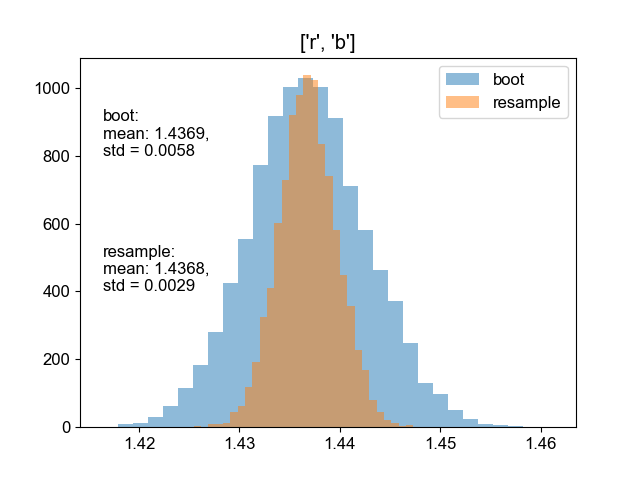

In [42]:
fig,ax = plt.subplots()
ax.hist(error_results['n_result_error_b'],30,alpha=0.5,label='boot')
ax.text(min(error_results['n_result_error_b']), 800,
        f"boot:\nmean: {round(error_results['mean_n_b'], 4)}, \nstd = {round(error_results['std_n_b'], 4)}")

ax.hist(error_results['n_result_error_r'],30,alpha=0.5,label='resample')
ax.text(min(error_results['n_result_error_b']), 400,
        f"resample:\nmean: {round(error_results['mean_n_r'], 4)}, \nstd = {round(error_results['std_n_r'], 4)}")
ax.legend(loc='upper right')
ax.set_title(method)